<a href="https://colab.research.google.com/github/anshi-7/foraging/blob/master/MNE%20python%20group/Forging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install MNE version 1.8
!pip install mne==1.8.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.5 MB/s eta 0:00:00


In [2]:
# Import required libraries
import mne
import matplotlib.pyplot as plt

In [4]:

# Define the list of set files
set_files = ['31730.set', '43000.set', '47131.set', '47204.set', '47324.set', '48238.set']

# Load each .set file into an MNE Raw object
raw_list = []
for fname in set_files:
    print(f"Loading {fname} ...")
    raw = mne.io.read_raw_eeglab(fname, preload=True)
    raw_list.append(raw)

# For demonstration, we will process the first file in the list
raw = raw_list[0]

# -------------------------------
# STEP 1: Plot PSD of the raw data
# -------------------------------
print("Plotting PSD of the raw data...")
raw.plot_psd(fmin=0.5, fmax=100, show=True)




Loading 31730.set ...


OSError: could not read bytes

In [ ]:

# -------------------------------
# STEP 2: Clean the data
#   2.1. Since line noise is known to be 60 Hz in America, we directly apply a notch filter.
# -------------------------------
print("Applying notch filter at 60 Hz to remove line noise...")
raw_clean = raw.copy().notch_filter(freqs=[60], verbose=False)


# -------------------------------
#   2.2. We apply a bandpass filter between 0.5 and 90 Hz.
# -------------------------------
print("Applying bandpass filter (0.5 - 90 Hz) on the cleaned data...")
raw_clean.filter(l_freq=0.5, h_freq=90, verbose=False)



Applying notch filter at 60 Hz to remove line noise...
Applying bandpass filter (0.5 - 90 Hz) on the cleaned data...


<RawEEGLAB | 31730.set, 19 x 1322500 (5290.0 s), ~191.7 MB, data loaded>

Plotting PSD of the cleaned data...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


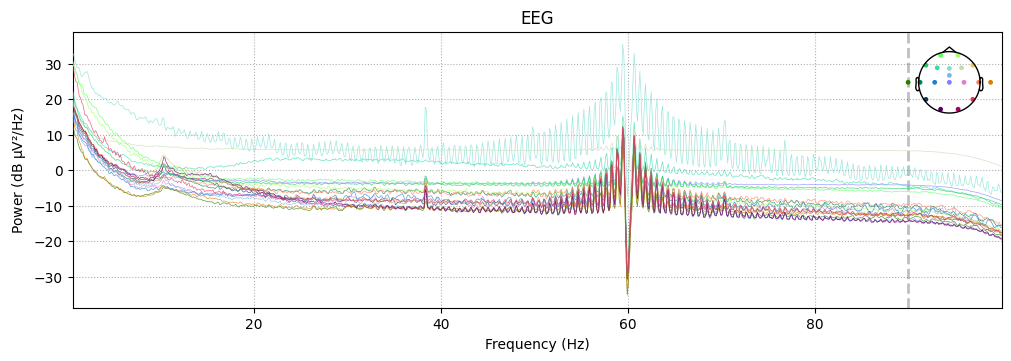

In [ ]:

# -------------------------------
# STEP 3: Plot the PSD of the cleaned data
# -------------------------------
print("Plotting PSD of the cleaned data...")
raw_clean.plot_psd(fmin=0.5, fmax=100, show=True)

plt.show()

In [ ]:

# -------------------------------
# STEP 3: Marker Extraction
# -------------------------------

print("Extracting event markers from annotations...")

# We try to retrieve annotations from the cleaned raw data
annotations = raw_clean.annotations
print("Annotations:")
print(annotations)

# We assume that each annotation's description has a format like "TRIGGER EVENT X".
unique_markers = set(desc.split()[-1].strip() for desc in annotations.description)
print("Unique marker letters extracted:", unique_markers)

# We initialize a dictionary to count trials for each condition:
# - 'pre_short' and 'pre_long' for prestress conditions;
# - 'post_short' and 'post_long' for poststress conditions.
trial_counts = {"pre_short": 0, "pre_long": 0, "post_short": 0, "post_long": 0}

# We use a variable to keep track of the current stress condition based on block markers.
current_block = None

# Loop over all annotations in time order.
# Marker codes (as expected) are:
#   B: Start of prestress block
#   I: Start of poststress block
#   T: Travel time ~5s   -> short environment trial
#   U: Travel time ~20s  -> long environment trial

for onset, desc in zip(annotations.onset, annotations.description):
    # We will extract the marker letter from the annotation by taking the last token.
    marker = desc.split()[-1].strip()

    if marker == 'B':
        current_block = 'pre'
    elif marker == 'I':
        current_block = 'post'
    # Only count travel time markers if we have a valid current block
    elif marker in ['T', 'U'] and current_block is not None:
        if marker == 'T':
            trial_counts[f"{current_block}_short"] += 1
        elif marker == 'U':
            trial_counts[f"{current_block}_long"] += 1

print("Trial counts per environment:")
print(trial_counts)

Extracting event markers from annotations...
Annotations:
<Annotations | 896 segments: TRIGGER EVENT A (1), TRIGGER EVENT B (1), ...>
Unique marker letters extracted: {'P', 'O', 'H', 'S', 'N', 'M', 'R', '22', 'F', 'C', 'B', 'U', 'I', 'E', 'J', 'D', 'T', 'X', 'G', 'Z', 'A', 'Q'}
Trial counts per environment:
{'pre_short': 41, 'pre_long': 32, 'post_short': 41, 'post_long': 34}
